In [1]:
!pip install wfdb

  Could not fetch URL https://pypi.python.org/simple/wfdb/: There was a problem confirming the ssl certificate: [SSL: TLSV1_ALERT_PROTOCOL_VERSION] tlsv1 alert protocol version (_ssl.c:661) - skipping
  Could not find a version that satisfies the requirement wfdb (from versions: )
No matching distribution found for wfdb


In [2]:
import os
import sys
from glob import glob
import numpy as np
import pandas as pd
import wfdb
# import biosignalsnotebooks as bsnb
from wfdb import processing
from matplotlib import pyplot as plt
# from scipy import signal
# from biosppy.signals import ecg
np.set_printoptions(threshold=sys.maxsize)
import umap
import sklearn.utils as slu
from sklearn.model_selection import LeaveOneOut

In [ ]:
# store = '/Users/ruchira/Documents/lvl_4_project/lvl4-hons-project/mit-bih-arrhythmia-database-1.0.0/100'
# record = wfdb.rdrecord(store, sampto=100)
# # wfdb.plot_wfdb(record, title='Record 100 from MIT-BIH Arrhythmia database') 
# # display(record.__dict__)

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

In [4]:
def get_data(path):
    file_path = glob(path)
    files = [i[:-4] for i in file_path]
    files.sort()
    return files

In [6]:
path = '/Users/ruchira/Documents/lvl_4_project/lvl4-hons-project/mit-bih-arrhythmia-database-1.0.0/*.atr'
# path = '/content/drive/MyDrive/ecg/mit-bih-arrhythmia-database-1.0.0/*.atr'
file_list = get_data(path)


## Histogram

(112647,)


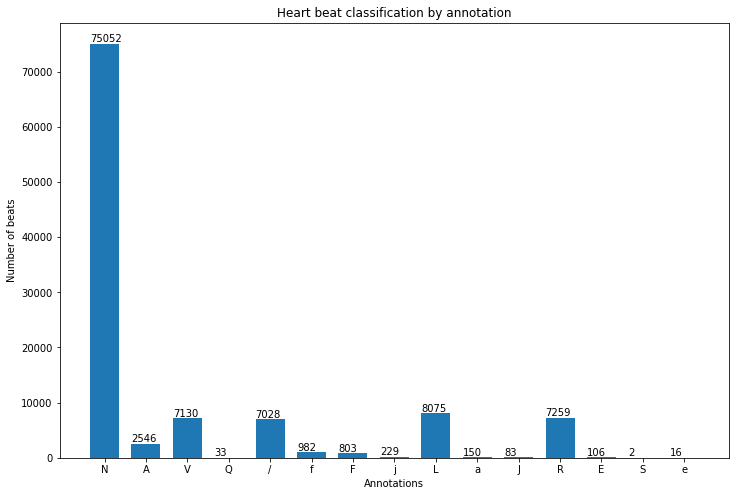

In [7]:

# print(len(get_data()))


ann_list = []
for i in range(len(file_list)): #going through each of the 48 files...
    data_file = file_list[i] #one file of the 48
    record = wfdb.rdsamp(data_file)  #returns an array of the sample
    ann_ref = wfdb.rdann(data_file, 'atr') #reading annotations in the file
    ann_list.extend(ann_ref.symbol)
    
ann_array = np.array(ann_list)
print(ann_array.shape)
# annp = wfdb.rdann(file_list[7], 'atr')
# print(len(annp.symbol))
# print(annp.label_store)



actual_beats = ['N','L','R','B','A','a','J','S','V','r',
             'F','e','j','n','E','/','f','Q','?']

ann_dict = {}

for i in ann_array:
    ann_dict[i] = ann_dict.get(i,0)+1

ann_dict = {k:v for k,v in ann_dict.items() if k in actual_beats}


plt.figure(figsize=(12,8))

xlocs, xlabs = plt.xticks()

bars = plt.bar(list(ann_dict.keys()), ann_dict.values(), width=.7)
plt.title("Heart beat classification by annotation")
xlocs = [i for i in ann_dict.keys()]
ylabs = [i for i in ann_dict.values()]

plt.xlabel("Annotations")
plt.ylabel("Number of beats")

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x(), yval + 300, yval)

# xlocs = [i/2 for i in range(len(ann_dict.keys()))]
# for i, v in enumerate(ann_dict.values()):
#     plt.text((xlocs[i] - 0.25, v + 0.01, str(v)))

# print(np.array(ann_ref.symbol).shape)
# print(record[1].get('fs'))
# print(record[0].shape)
# print(len(ann_ref.num)) #prints number of annotations (no of beats) 
# # num is the labelled annotation number for each annotation
# print(ann_ref.symbol)

## Load beats and center them

In [ ]:
for file in file_list:
    
    path = file.split('/')
    fn = path[-1]
    record = wfdb.rdsamp(file)
    ecg_val = record[0].T # 2, 650000
    ann_ref = wfdb.rdann(file,'atr')
    ann_list = np.array(ann_ref.symbol)
    ann_number = np.zeros_like(ann_list, dtype='float')
    
    # encode the annotations as numbers
    for annid, anno in enumerate(ann_list):
        if anno == 'N':
            ann_number[annid] = 1.0
        elif anno == 'L':
            ann_number[annid] = 2.0
        elif anno == 'R':
            ann_number[annid] = 3.0
        elif anno == 'A':
            ann_number[annid] = 4.0
        elif anno == 'V':
            ann_number[annid] = 5.0
        elif anno == 'F':
            ann_number[annid] = 6.0
        elif anno == 'f':
            ann_number[annid] = 7.0
        elif anno == '/':
            ann_number[annid] = 8.0
            
    all_ann_numbers = np.zeros_like(ecg_val[0], dtype='float')
    all_ann_numbers[ann_ref.sample] = ann_number
    
    for ch_id, channel in enumerate(ecg_val): #enumerates the 2 channels - so 0 and 1
        channel_name = record[1].get('sig_name')[ch_id]
        print("ECG channel: ", channel_name)
        
        # ecg_output = ecg.ecg(signal=channel, sampling_rate=360, show=False)
        
        # center the r peak
        rpeak_indices = ann_ref.sample[1:-1] #2272
        all_beats = []
        for i,peak in enumerate(rpeak_indices):
            start,end = peak-256//2, peak+256//2
            if start < 0:
                start = 0
            diff = 256 - len(channel[start:end])
            if diff > 0:
                padding = np.zeros(diff, dtype='float')
                padded_channel = np.append(padding, channel[start:end])
                all_beats.append(padded_channel)
            else:
                all_beats.append(channel[start:end])

#         for i, i_val in enumerate(rpeak_indices):
            # obtain annotation for each beat
            if peak < 10:
                from_i = 0
            else:
                from_i = peak - 10
            to_i = peak + 10
            anno = all_ann_numbers[from_i:to_i].max()

            
            # standardise the data
            all_beats[i] = (all_beats[i]-np.mean(all_beats[i]))/np.std(all_beats[i])
            
            # append the annotation to each beat
            all_beats[i] = np.append(all_beats[i], anno)
            
            # append file number
            all_beats[i] = np.append(all_beats[i], fn)

            # append channel number (0 or 1)
            all_beats[i] = np.append(all_beats[i], ch_id)
        
        # save to file per patient
        all_beats = np.array(all_beats, dtype='float64')
        savedata = all_beats 
        outfn = './data_ecg/'+fn+'_'+channel_name+'.csv'
        print('    Generating ', outfn)
        if not os.path.exists('./data_ecg/'):
            os.makedirs('./data_ecg/')
        with open(outfn, "wb") as fin:
            np.savetxt(fin, savedata, delimiter=",", fmt='%f')

ECG channel:  MLII
    Generating  /content/drive/MyDrive/ecg/data_ecg/100_MLII.csv
ECG channel:  V5
    Generating  /content/drive/MyDrive/ecg/data_ecg/100_V5.csv
ECG channel:  MLII
    Generating  /content/drive/MyDrive/ecg/data_ecg/101_MLII.csv
ECG channel:  V1
    Generating  /content/drive/MyDrive/ecg/data_ecg/101_V1.csv
ECG channel:  V5
    Generating  /content/drive/MyDrive/ecg/data_ecg/102_V5.csv
ECG channel:  V2
    Generating  /content/drive/MyDrive/ecg/data_ecg/102_V2.csv
ECG channel:  MLII
    Generating  /content/drive/MyDrive/ecg/data_ecg/103_MLII.csv
ECG channel:  V2
    Generating  /content/drive/MyDrive/ecg/data_ecg/103_V2.csv
ECG channel:  V5
    Generating  /content/drive/MyDrive/ecg/data_ecg/104_V5.csv
ECG channel:  V2
    Generating  /content/drive/MyDrive/ecg/data_ecg/104_V2.csv
ECG channel:  MLII
    Generating  /content/drive/MyDrive/ecg/data_ecg/105_MLII.csv
ECG channel:  V1
    Generating  /content/drive/MyDrive/ecg/data_ecg/105_V1.csv
ECG channel:  MLII
    G

In [ ]:
all_data = np.empty(shape=[0,259])
print(all_data.shape)
csv_files = glob('./data_ecg/*.csv')

for file in csv_files:
    heartbeat = np.loadtxt(file, delimiter=',')
    all_data = np.append(all_data, heartbeat, axis=0)

print("loaded all data")
print(all_data.shape)

(0, 259)
loaded all data
(160854, 259)


## Delete beats that have not been annotated

In [ ]:
# beats with no annotation
no_anno = np.where(all_data[:,-3]==0.0)[0]
# delete
all_data = np.delete(all_data, no_anno,0)



# print(np.where(all_data[:,-3]==1.0)[0].shape)
# print(np.where(all_data[:,-3]==2.0)[0].shape)
# print(np.where(all_data[:,-3]==3.0)[0].shape)
# print(np.where(all_data[:,-3]==4.0)[0].shape)
# print(np.where(all_data[:,-3]==5.0)[0].shape)
# print(np.where(all_data[:,-3]==6.0)[0].shape)
# print(np.where(all_data[:,-3]==7.0)[0].shape)
# print(np.where(all_data[:,-3]==8.0)[0].shape)




# print(np.where(all_data[:,-3]==0.0)[0])
# print(150034+16144+14512+5088+14260+1606+1964+14048+7446)


# ann_value = all_data[:,-3]
# print(">>>>>>>>",all_data[a==0.0])



[   228    404    528    533    628    633    665    672    673   1194
   1199   1845   2339   2348   2351   2362   3267   3301   3303   3315
   3319   4075   4088   4090   4104   4108   4112   4773   4804   6103
   6112   6115   6126   6129   6138   6249   6254   6360   6363   6622
   6627   6646   6652   7824   7833   8367   8372   8589   8594   8641
   8643   8644   8645   8646   8647   8650   8680   8685   8698   8713
   8748   8754   8761   8769   8772   8779   8784   8785   8789   8791
   8795   8807   8809   8814   8817   8826   8828   8847   8848   8849
   8851   8853   8860   8867   8879   8906   8907   8910   8921   8936
   8940   8944   8947   8961   8988   8989   8990   8991   8995   8996
   8997   8998   8999   9000   9001   9002   9003   9004   9022   9026
   9053   9061   9075   9086   9089   9119   9136   9152   9162   9170
   9205   9220   9233   9244   9247   9256   9263   9267   9297   9304
   9330   9338   9349   9357   9367   9374   9382   9388   9423   9430
   944

In [ ]:
# print(150034+16144+14512+5088+14260+1606+1964)
# # print(all_data_new.shape)
print(all_data.shape)

(156684, 259)


## Visualise the heartbeats

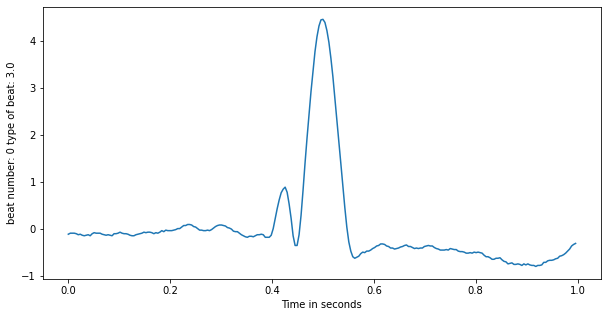

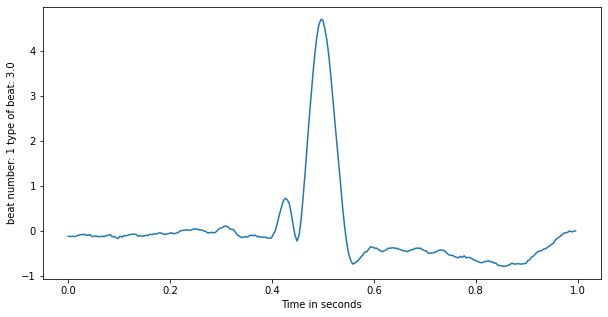

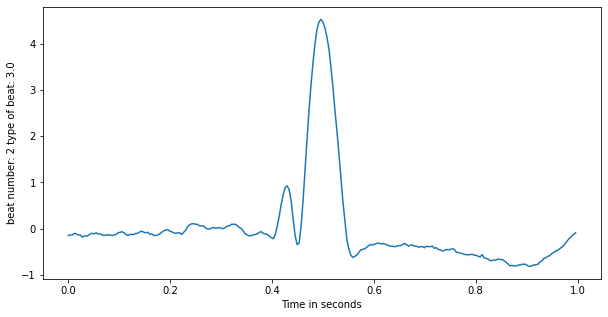

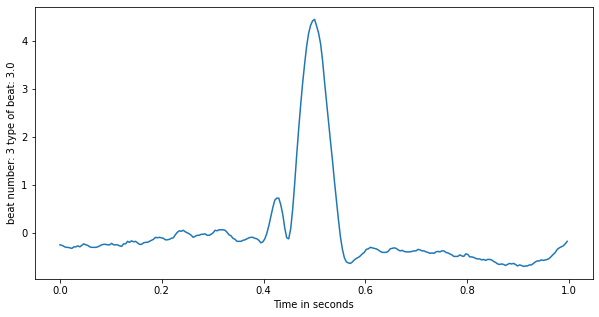

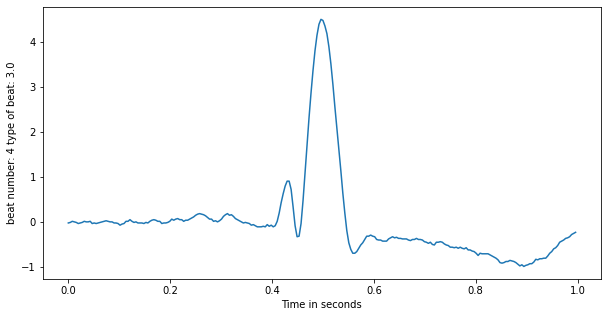

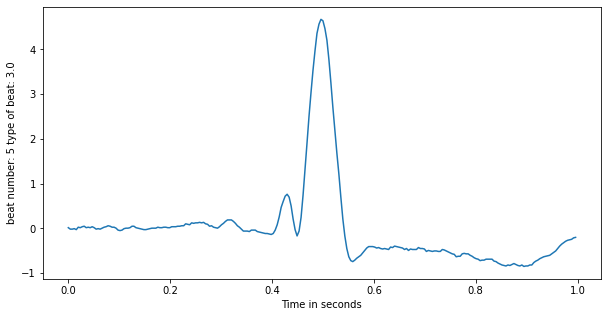

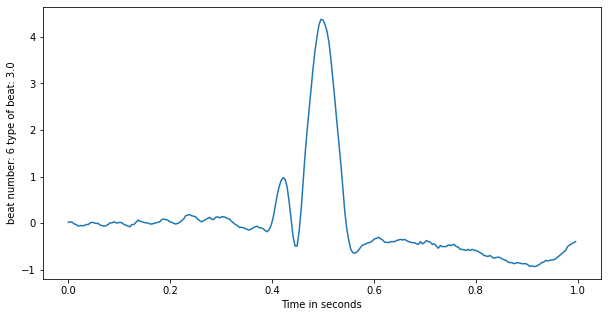

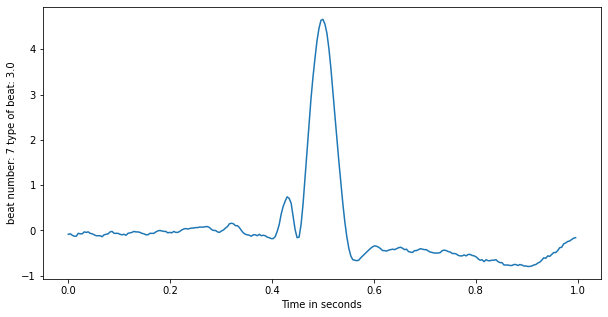

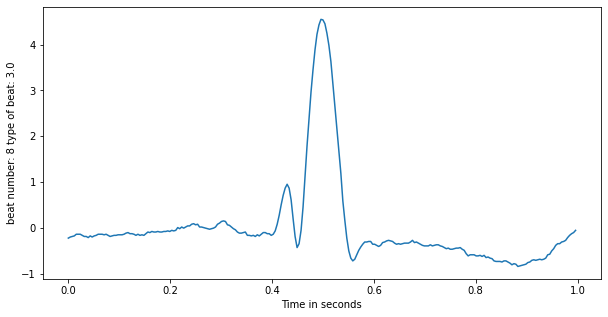

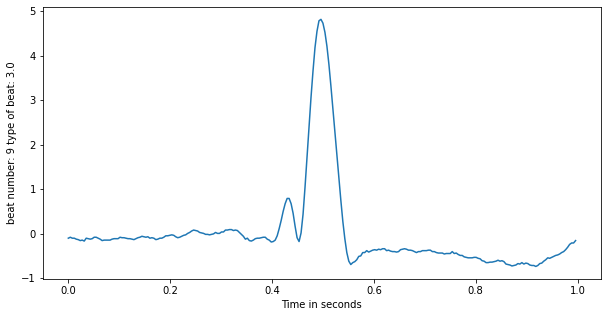

In [ ]:
# data = np.loadtxt('/Users/ruchira/Documents/lvl_4_project/lvl4-hons-project/notebooks/data_ecg/100_MLII.csv', delimiter=',')
# data = all_data[0]
# print(data.shape)
# print(data[-2], data[-1])

ann_value = all_data[:,-3]
a = all_data[ann_value==3.0]

for i in range(10):
    data = a[i]
# for beat_num in [7]:
    time_value = np.arange(256, dtype = 'float') / 256
    current_beat = data[:-3]
    ann_num = data[-3]
    plt.figure(figsize=(10,5))
    plt.plot(time_value, current_beat)
    plt.xlabel('Time in seconds')
    plt.ylabel('beat number: ' + str(i) + ' type of beat: ' + str(ann_num))

## Histogram of Unsampled beats after pre-processing

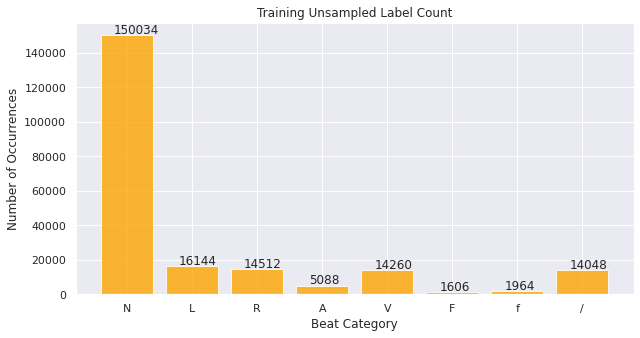

In [ ]:
import seaborn as sns
sns.set()
feature_names = ['N','L','R','A','V','F','f','/']

dftrain = pd.DataFrame(all_data)
countstrain = dftrain[256].value_counts()

plt.figure(figsize=(10,5))
barplt = plt.bar(countstrain.index, countstrain.values, alpha=0.8, color='orange')
plt.title('Training Unsampled Label Count')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Beat Category', fontsize=12)
plt.xticks(ticks=[1,2,3,4,5,6,7,8],labels=feature_names)
for bar in barplt:
    yval = bar.get_height()
    plt.text(bar.get_x()+.2, yval+1000, yval)
plt.show()

## Test Train Split

In [ ]:
shuffled_all = all_data
np.random.shuffle(shuffled_all)

In [ ]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(shuffled_all, test_size=0.25)

print(train.shape)
print(test.shape)


(117513, 259)
(39171, 259)


In [ ]:
train_file = '/content/drive/MyDrive/ecg/train_test_imbal/train.csv'
test_file = '/content/drive/MyDrive/ecg/train_test_imbal/test.csv'



with open(train_file, 'wb') as f:
    np.savetxt(f, train, delimiter=",", fmt='%f')

with open(test_file, 'wb') as f:
    np.savetxt(f, test, delimiter=",", fmt='%f')


In [ ]:
# to load from files
path = '/content/drive/MyDrive/ecg'
train = np.loadtxt(path + '/train_test_imbal/train.csv', delimiter=',')
test = np.loadtxt(path+'/train_test_imbal/test.csv', delimiter=',')


In [ ]:
print(train.shape)
print(test.shape)


(117513, 259)
(39171, 259)


## SMOTE

In [ ]:
from imblearn.over_sampling import SMOTE
from collections import Counter

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
label_count = Counter(train[:,-3])
print(label_count)
classes, counts = np.unique(train[:,-3], return_counts=True)
imbalanced = counts[1:]
imb_max = np.max(imbalanced)
print(imb_max)
normal_count = counts[0]
print(normal_count)

Counter({1.0: 78355, 2.0: 12093, 3.0: 8340, 8.0: 8230, 5.0: 7089, 6.0: 1177, 4.0: 1173, 7.0: 1056})
12093
78355


In [ ]:
samp_strat = {1:normal_count,2:imb_max,3:imb_max,4:imb_max,5:imb_max,6:imb_max,7:imb_max, 8:imb_max}
sm = SMOTE(random_state=42, sampling_strategy=samp_strat)
train_bal = sm.fit_resample(train, train[:,-3])

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

In [ ]:
print(Counter(train_bal[1]))

Counter({1.0: 78355, 2.0: 12093, 8.0: 12093, 3.0: 12093, 5.0: 12093, 7.0: 12093, 6.0: 12093, 4.0: 12093})


In [ ]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler()
train_up = rus.fit_resample(train_bal[0], train_bal[1])

print(Counter(train_up[1]))

Counter({1.0: 12093, 2.0: 12093, 3.0: 12093, 4.0: 12093, 5.0: 12093, 6.0: 12093, 7.0: 12093, 8.0: 12093})


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


## Histogram of sampled pre-processed data

(96744, 257)


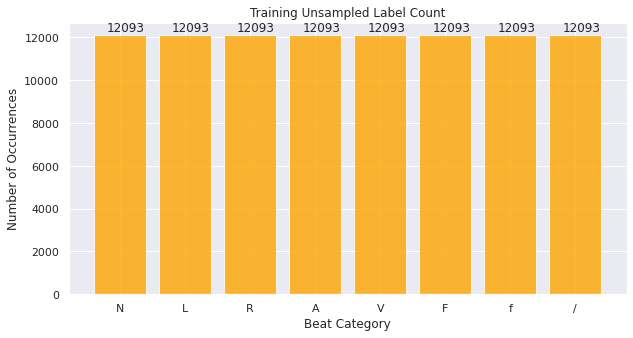

In [ ]:
import seaborn as sns
sns.set()
feature_names = ['N','L','R','A','V','F','f','/']

dftrain = pd.DataFrame(train_up[0][:,:-2])
print(dftrain.shape)
countstrain = dftrain[256].value_counts()

plt.figure(figsize=(10,5))
barplt = plt.bar(countstrain.index, countstrain.values, alpha=0.8, color='orange')
plt.title('Training Unsampled Label Count')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Beat Category', fontsize=12)
plt.xticks(ticks=[1,2,3,4,5,6,7,8],labels=feature_names)
for bar in barplt:
    yval = bar.get_height()
    plt.text(bar.get_x()+.2, yval+200, yval)
plt.show()

In [ ]:
X_train = train_up[0][:,:-3]
y_train = train_up[0][:,-3]
X_test = test[:,:-3]
y_test = test[:,-3]

## CF Matrix and Scores Functions

In [ ]:
from sklearn.metrics import *
import seaborn as sns
def cf_matrix_func(predictions, y_test):
    cm = confusion_matrix(y_test, predictions)
    categories=['N', 'L', 'R', 'A', 'V', 'F', 'f','P']
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10,10))
    sns.heatmap(cm, annot=True, 
                fmt='.2%', cmap='Blues',xticklabels=categories,yticklabels=categories)
    plt.xlabel('predicted label')
    plt.ylabel('true label')
    
def scores(predictions, y_test):
    accuracy = accuracy_score(y_test, predictions)
    precision_micro = precision_score(y_test, predictions, average='micro', labels=[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0,8.0])
    precision_macro = precision_score(y_test, predictions, average='macro', labels=[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0,8.0])
    f1_macro = f1_score(y_test, predictions, average='macro', labels=[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0,8.0])
    f1_micro = f1_score(y_test, predictions, average='micro', labels=[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0,8.0])
    print("accuracy: ", accuracy, "precision_macro: ", precision_macro, "precision_micro: ", precision_micro, "f1_macro: ", f1_macro, "f1_micro: ", f1_micro)
    return accuracy, precision_macro, precision_micro, f1_macro, f1_micro

##XGBoost Classifier


In [ ]:
from xgboost import XGBClassifier

model = XGBClassifier()
model.fit(X_u, y_u,verbose=2)
# print(model.score(X_test, y_test))
print(model)

NameError: ignored

In [ ]:
pred_xgb = model.predict(X_test)

In [ ]:
print(scores(pred_xgb, y_test))
cf_matrix_func(pred_xgb, y_test)

## CNN Classifier

In [ ]:
from keras.utils.np_utils import to_categorical
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D

In [ ]:
# print(train_balanced[:,-1])

In [ ]:
X_train_3d = X_train.reshape(-1, X_train.shape[1],1)
X_test_3d = X_test.reshape(-1, X_test.shape[1], 1)

print(X_train_3d.shape)
print(X_test_3d.shape)

y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)
print(y_train_cat.shape)
print(y_test_cat.shape)

(96744, 256, 1)
(39171, 256, 1)
(96744, 9)
(39171, 9)


In [ ]:
verbose, epoch, batch_size = 1, 10, 128

def getModel():
    cnnmodel = Sequential()
    cnnmodel.add(Conv1D(filters=128, kernel_size=2, activation='relu',input_shape=(X_train_3d.shape[1],X_train_3d.shape[2])))
    cnnmodel.add(MaxPooling1D(pool_size=2))
    cnnmodel.add(Conv1D(filters=64, kernel_size=2, activation='relu'))
    cnnmodel.add(MaxPooling1D(pool_size=2))
    cnnmodel.add(Conv1D(filters=32, kernel_size=2, activation='relu'))
    cnnmodel.add(MaxPooling1D(pool_size=2))
    cnnmodel.add(Conv1D(filters=16, kernel_size=2, activation='relu'))
    cnnmodel.add(MaxPooling1D(pool_size=2))
    cnnmodel.add(Dropout(rate=0.2))
    cnnmodel.add(Flatten())
    cnnmodel.add(Dense(64, activation='relu'))
    cnnmodel.add(Dense(32, activation='relu'))
    cnnmodel.add(Dense(9, activation='softmax'))
    cnnmodel.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
    cnnmodel.summary()
    return cnnmodel

cnnmodel = getModel()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_8 (Conv1D)            (None, 255, 128)          384       
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 127, 128)          0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 126, 64)           16448     
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 63, 64)            0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 62, 32)            4128      
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 31, 32)            0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 30, 16)           

In [ ]:
model = cnnmodel.fit(X_train_3d, y_train_cat, epochs=epoch, validation_split=0.2, verbose=verbose,batch_size=batch_size)

Epoch 1/10
605/605 [==============================] - 6s 8ms/step - loss: 0.9854 - accuracy: 0.6311 - val_loss: 0.2299 - val_accuracy: 0.9310
Epoch 2/10
605/605 [==============================] - 5s 8ms/step - loss: 0.2884 - accuracy: 0.9071 - val_loss: 0.1725 - val_accuracy: 0.9441
Epoch 3/10
605/605 [==============================] - 5s 8ms/step - loss: 0.2173 - accuracy: 0.9282 - val_loss: 0.1304 - val_accuracy: 0.9572
Epoch 4/10
605/605 [==============================] - 5s 8ms/step - loss: 0.1792 - accuracy: 0.9415 - val_loss: 0.1128 - val_accuracy: 0.9617
Epoch 5/10
605/605 [==============================] - 5s 8ms/step - loss: 0.1515 - accuracy: 0.9502 - val_loss: 0.1018 - val_accuracy: 0.9649
Epoch 6/10
605/605 [==============================] - 5s 8ms/step - loss: 0.1423 - accuracy: 0.9525 - val_loss: 0.0892 - val_accuracy: 0.9705
Epoch 7/10
605/605 [==============================] - 5s 8ms/step - loss: 0.1277 - accuracy: 0.9572 - val_loss: 0.0880 - val_accuracy: 0.9702
Epoch 

In [ ]:
cnnpredictions = cnnmodel.predict(X_test_3d, verbose=1)

1225/1225 [==============================] - 2s 1ms/step


In [ ]:
cnn_predict = np.argmax(cnnpredictions, axis=1)
true_value = np.argmax(y_test_cat,axis=1)

accuracy:  0.9449082229200173 precision_macro:  0.9457735148753319 precision_micro:  0.9449082229200173 f1_macro:  0.8307281778675035 f1_micro:  0.9449082229200173


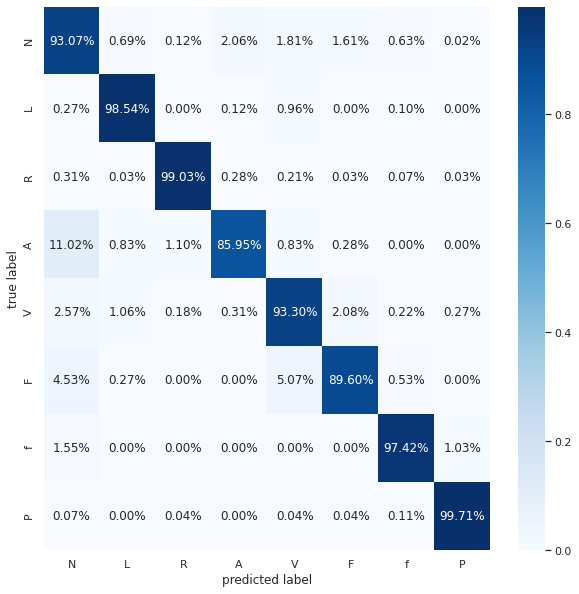

In [ ]:
score = scores(true_value, cnn_predict)

cf_matrix_func(cnn_predict,true_value)